In [164]:
# If needed:
# !pip install yfinance pandas-datareader --quiet

import warnings, numpy as np, pandas as pd, yfinance as yf, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8,4)

In [165]:
# ---- User config ----
START = "2009-01-01"
END   = "2025-10-23"
FREQ  = "W-FRI"      # options: "D", "W-FRI", "BM" (business month-end)

# Choose your panel units (country indices example)
EQUITY_TICKERS = {
    "S&P": "^GSPC",
    #"DJI": "^DJI",
    "UKX": "^FTSE",
    #"NYA": "^NYA",
    "JP": "^N225",       # Nikkei 225

}

# Rates via Yahoo
YAHOO_3M = "^IRX"   # 3M T-bill (1.00 ≈ 1 bp)
YAHOO_10Y = "^TNX"  # 10Y Treasury (1.00 ≈ 10 bp)

# Transition variable candidate (example): VIX level
VIX_TICKER = "^VIX"

# Choice of x (regressor): "US_10Y" or "US_3M"
X_SOURCE = "US_10Y"


In [166]:
def _resample_last(df, freq):
    return df.resample(freq).last()

def fetch_equities_yahoo(ticker_map, start, end, freq):
    frames = []
    for unit, ticker in ticker_map.items():
        px = yf.download(ticker, start=start, end=end, progress=False)[["Close"]]
        px.columns = [unit]
        frames.append(px)
    wide = pd.concat(frames, axis=1).dropna(how="all")
    wide = _resample_last(wide, freq).dropna(how="any")
    return wide

def fetch_vix_yahoo(start, end, freq):
    vix = yf.download(VIX_TICKER, start=start, end=end, progress=False)[["Close"]]
    vix.columns = ["VIX"]
    vix = _resample_last(vix, freq).dropna()
    return vix["VIX"]

def fetch_rates_yahoo(start, end, freq):
    irx = yf.download(YAHOO_3M, start=start, end=end, progress=False)[["Close"]].rename(columns={"Close":"IRX"})
    tnx = yf.download(YAHOO_10Y, start=start, end=end, progress=False)[["Close"]].rename(columns={"Close":"TNX"})
    rates = pd.concat([irx, tnx], axis=1)
    rates = _resample_last(rates, freq).dropna()
    out = pd.DataFrame(index=rates.index)
    out["US_3M_level_yahoo"]  = rates["IRX"]
    out["US_10Y_level_yahoo"] = rates["TNX"]
    # Convert to basis points (see Yahoo scaling notes)
    out["d_US_3M_bps"]  = rates["IRX"].diff()            # ^IRX: 1.00 ≈ 1 bp
    out["d_US_10Y_bps"] = rates["TNX"].diff() * 10.0     # ^TNX: 1.00 ≈ 10 bp
    return out.dropna()

def log_returns(levels_df):
    return np.log(levels_df).diff().dropna()

def to_long_panel(wide_df, name):
    out = wide_df.stack().rename(name).to_frame()
    out.index.set_names(["date", "unit"], inplace=True)
    return out.reset_index()

def build_panel(px_wide, rates_df, q_series, x_source="US_10Y"):
    # 1) y: log-returns per unit
    r_wide = log_returns(px_wide)
    y_long = to_long_panel(r_wide, "y")

    # 2) x: Δrates (bps)
    if x_source == "US_10Y":
        x = rates_df["d_US_10Y_bps"].copy()
    elif x_source == "US_3M":
        x = rates_df["d_US_3M_bps"].copy()
    else:
        raise ValueError("x_source must be 'US_10Y' or 'US_3M'")
    x = x.rename("x").dropna()

    # 3) q: transition variable series (e.g., VIX or 10Y level)
    q = (q_series if isinstance(q_series, pd.Series) else q_series.iloc[:,0]).rename("q").dropna()

    # 4) Align dates
    common_idx = r_wide.index.intersection(x.index).intersection(q.index)
    r_wide = r_wide.loc[common_idx]
    x = x.loc[common_idx]
    q = q.loc[common_idx]

    # Broadcast x & q across units
    x_long = pd.DataFrame({"date": common_idx, "x": x.values})
    q_long = pd.DataFrame({"date": common_idx, "q": q.values})
    panel = to_long_panel(r_wide, "y").merge(x_long, on="date").merge(q_long, on="date")

    # Standardize q for numerical stability
    panel["q_std"] = (panel["q"] - panel["q"].mean()) / panel["q"].std(ddof=0)

    # Balance the panel (drop units with missing rows)
    counts = panel.groupby("unit")["date"].count()
    Tmax = counts.max()
    keep = counts[counts == Tmax].index
    panel_bal = panel[panel["unit"].isin(keep)].reset_index(drop=True)

    return panel_bal[["date","unit","y","x","q","q_std"]]


In [167]:
# Fetch
px    = fetch_equities_yahoo(EQUITY_TICKERS, START, END, FREQ)
rates = fetch_rates_yahoo(START, END, FREQ)
vix   = fetch_vix_yahoo(START, END, FREQ)              # transition variable q

# Build PSTR-ready panel
panel = build_panel(px_wide=px, rates_df=rates, q_series=vix, x_source= X_SOURCE)

# Basic description
print("Panel shape:", panel.shape)
print(panel.head(3))

# Count per unit and date coverage
print("\nObs per unit:")
print(panel.groupby("unit")["date"].count())

print("\nDate range:", panel["date"].min().date(), "→", panel["date"].max().date())

# Summary stats of y (returns), x (Δrates in bps), q (transition)
desc = panel[["y","x","q"]].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
desc


Panel shape: (2625, 6)
        date unit         y         x          q     q_std
0 2009-01-16  S&P -0.046237 -1.030002  46.110001  3.596887
1 2009-01-16  UKX -0.070158 -1.030002  46.110001  3.596887
2 2009-01-16   JP -0.071121 -1.030002  46.110001  3.596887

Obs per unit:
unit
JP     875
S&P    875
UKX    875
Name: date, dtype: int64

Date range: 2009-01-16 → 2025-10-24


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
y,2625.0,0.001713,0.024755,-0.18593,-0.069985,-0.037768,-0.010732,0.003000,0.015368,0.038325,0.062344,0.158171
x,2625.0,0.017371,1.203100,-4.21000,-2.938399,-1.820000,-0.760000,-0.060000,0.739999,2.120001,3.320801,5.080001
q,2625.0,18.962880,7.548830,9.14000,9.619600,11.292000,13.700000,16.879999,21.850000,33.815999,46.057200,66.040001


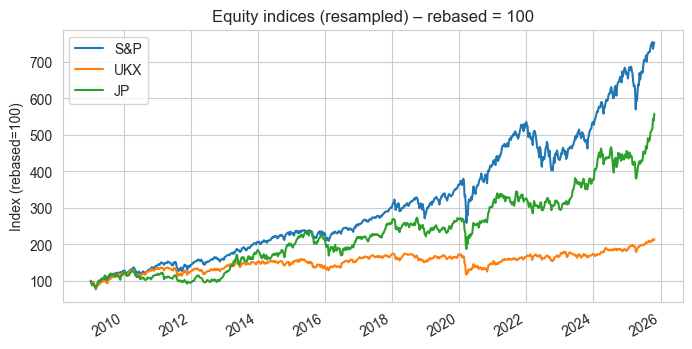

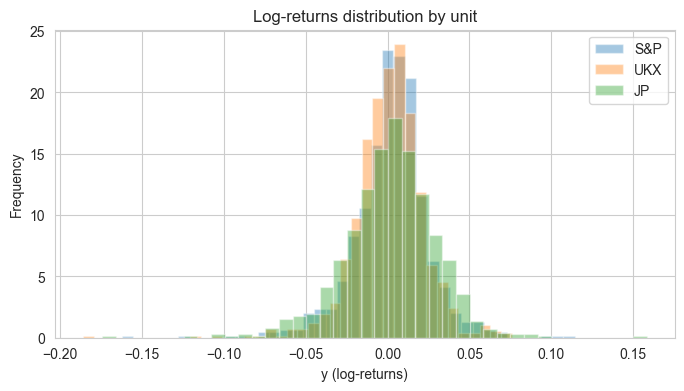

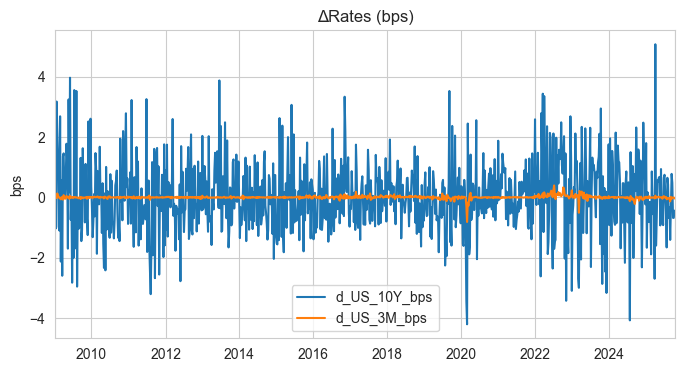

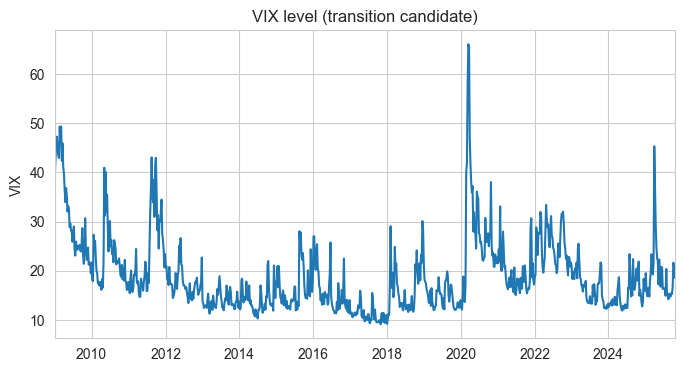

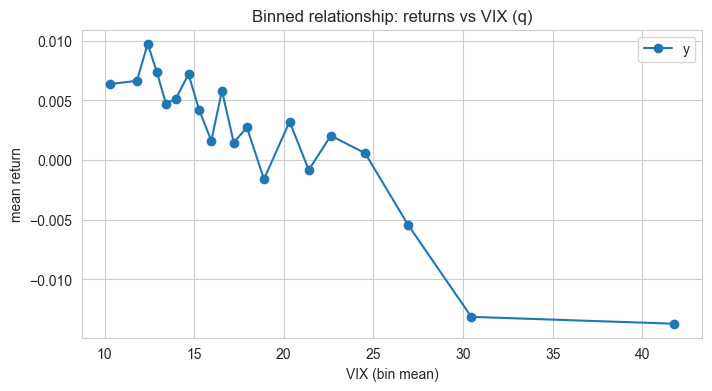

          y         x         q
y  1.000000  0.239207 -0.242549
x  0.239207  1.000000 -0.073964
q -0.242549 -0.073964  1.000000


In [168]:
# 5.1 Levels: equity prices (resampled)
(px / px.iloc[0] * 100).plot(title="Equity indices (resampled) – rebased = 100")
plt.xlabel(""); plt.ylabel("Index (rebased=100)"); plt.show()

# 5.2 y: returns distribution by unit (hist)
for u in panel["unit"].unique():
    panel.loc[panel["unit"]==u, "y"].plot(kind="hist", bins=40, alpha=0.4, density=True, label=u)
plt.title("Log-returns distribution by unit")
plt.xlabel("y (log-returns)"); plt.legend(); plt.show()

# 5.3 x & q over time (one plot per series, shared across units since x,q are common here)
rates[["d_US_10Y_bps","d_US_3M_bps"]].plot(title="ΔRates (bps)")
plt.xlabel(""); plt.ylabel("bps"); plt.show()

vix.plot(title="VIX level (transition candidate)")
plt.xlabel(""); plt.ylabel("VIX"); plt.show()

# 5.4 Return vs. transition (bin scatter of y on q)
tmp = panel.copy()
tmp["q_bin"] = pd.qcut(tmp["q"], q=20, duplicates="drop")
bin_means = tmp.groupby("q_bin")[["q","y"]].mean()
bin_means.plot(x="q", y="y", kind="line", marker="o", title="Binned relationship: returns vs VIX (q)")
plt.xlabel("VIX (bin mean)"); plt.ylabel("mean return"); plt.show()

# 5.5 Simple correlations (pooled)
corr = panel[["y","x","q"]].corr()
print(corr)


NA counts:
 date     0
unit     0
y        0
x        0
q        0
q_std    0
dtype: int64


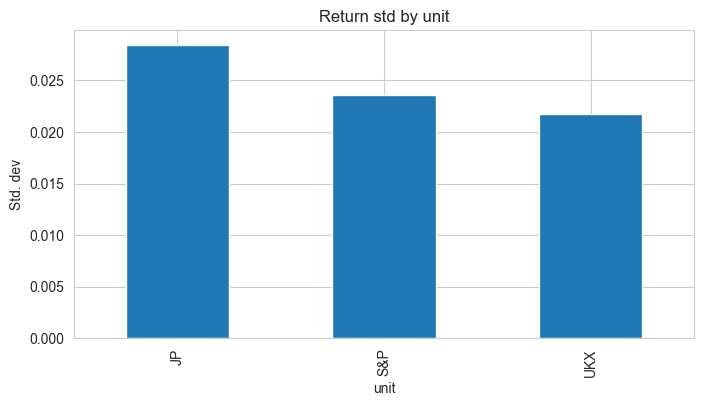

0.1    12.120000
0.5    16.879999
0.9    28.160000
Name: q, dtype: float64


In [169]:
# Missing values check
na_counts = panel.isna().sum()
print("NA counts:\n", na_counts)

# Stationarity intuition (not formal tests): look at hist/variance stability
panel.groupby("unit")["y"].std().plot(kind="bar", title="Return std by unit")
plt.ylabel("Std. dev"); plt.show()

# Quick check: are there observations across both sides of q (so regimes can be identified)?
print(panel["q"].quantile([0.1, 0.5, 0.9]))

In [170]:
# --- Linear fixed-effects benchmark: y_it = mu_i + tau_t + beta * x_it + u_it
import pandas as pd
import statsmodels.api as sm

def fit_linear_fe(panel: pd.DataFrame, time_fe: bool = True, cluster: str = "unit"):
    df = panel.copy()
    # Dummies (absorbed). For stability, use pandas C() via patsy-like design:
    # We'll build the design matrix manually to keep things explicit.
    y = df["y"].values
    X = df[["x"]].copy()

    # Add FE dummies
    D_unit = pd.get_dummies(df["unit"], drop_first=True, dtype=float)
    if time_fe:
        D_time = pd.get_dummies(df["date"], drop_first=True, dtype=float)
        X = pd.concat([X, D_unit, D_time], axis=1)
    else:
        X = pd.concat([X, D_unit], axis=1)

    X = sm.add_constant(X)  # intercept (will be collinear with dropped FE, so OK)

    model = sm.OLS(y, X)
    if cluster in ("unit", "date"):
        # cluster-robust covariance
        groups = df[cluster]
        res = model.fit(cov_type="cluster", cov_kwds={"groups": groups})
    else:
        res = model.fit()

    # Pull the beta on x (first column after const)
    beta_x = res.params.get("x", float("nan"))
    print(res.summary().tables[0])
    print("\nbeta_hat (x):", beta_x)
    return res

fe_res = fit_linear_fe(panel, time_fe=True, cluster="unit")


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                -4.371e+12
Date:                Mon, 03 Nov 2025   Prob (F-statistic):               1.00
Time:                        15:33:42   Log-Likelihood:                 7804.1
No. Observations:                2625   AIC:                        -1.385e+04
Df Residuals:                    1748   BIC:                            -8704.
Df Model:                         876                                         
Covariance Type:              cluster                                         

beta_hat (x): 0.02924129891155173


,mean,std,count
unit,,,
JP,0.001965,0.028433,875
S&P,0.002306,0.023604,875
UKX,0.000869,0.021750,875


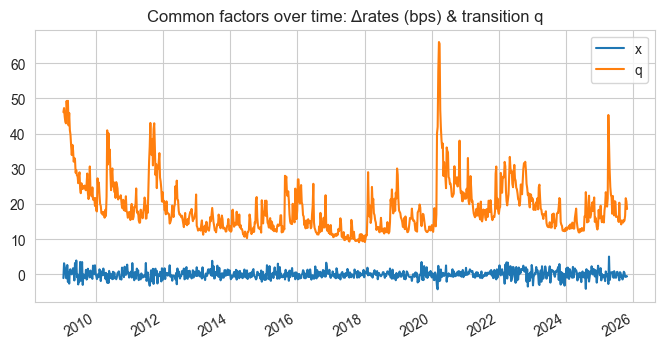

In [171]:
# Mean y by unit; mean x by date (common across units here)
display(panel.groupby("unit")["y"].agg(["mean","std","count"]))
panel.groupby("date")[["x","q"]].mean().plot(title="Common factors over time: Δrates (bps) & transition q")
plt.xlabel(""); plt.show()

In [172]:
import numpy as np

def unit_demean(s: pd.Series, unit: pd.Series) -> np.ndarray:
    df = pd.DataFrame({"s": s.values, "unit": unit.values})
    si = df.groupby("unit")["s"].transform("mean")
    return (df["s"] - si).values

def linearity_test_unitFE(panel):
    df = panel.copy()
    qz = (df["q"] - df["q"].mean()) / df["q"].std(ddof=0)

    y_dm  = unit_demean(df["y"],  df["unit"])
    x_dm  = unit_demean(df["x"],  df["unit"])
    xq_dm  = unit_demean(df["x"]*qz,    df["unit"])
    xq2_dm = unit_demean(df["x"]*(qz**2), df["unit"])
    xq3_dm = unit_demean(df["x"]*(qz**3), df["unit"])

    Xr = sm.add_constant(np.column_stack([x_dm]))
    rr = sm.OLS(y_dm, Xr).fit()

    Xu = sm.add_constant(np.column_stack([x_dm, xq_dm, xq2_dm, xq3_dm]))
    ur = sm.OLS(y_dm, Xu).fit()

    df_num, df_den = 3, ur.df_resid
    RSSr, RSSu = rr.ssr, ur.ssr
    F = ((RSSr - RSSu) / df_num) / (RSSu / df_den)
    from scipy.stats import f as fdist
    pF = 1 - fdist.cdf(F, df_num, df_den)
    print(f"Linearity test (unit FE only): F({df_num},{int(df_den)})={F:.3f}, p={pF:.4f}")
    return {"F":F, "pval":pF}


lin_test = linearity_test_unitFE(panel)


Linearity test (unit FE only): F(3,2620)=78.332, p=0.0000


In [173]:
import numpy as np, pandas as pd, statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def G_logistic(q_std, gamma, c):
    return 1.0 / (1.0 + np.exp(-gamma * (q_std - c)))

def pstr_objective_unitFE(params, df, qname="q_std"):
    gamma, c = params
    if gamma <= 1e-4:  # keep gamma positive
        return 1e12
    qstd = df[qname].values
    x = df["x"].values
    y = df["y"].values
    u = df["unit"]

    G = G_logistic(qstd, gamma, c)
    y_dm  = unit_demean(pd.Series(y), u)
    x_dm  = unit_demean(pd.Series(x), u)
    xG_dm = unit_demean(pd.Series(x * G), u)

    X = np.column_stack([x_dm, xG_dm])  # [x, x*G]
    beta_hat = np.linalg.lstsq(X, y_dm, rcond=None)[0]
    resid = y_dm - X @ beta_hat
    return float(resid @ resid)


In [174]:
def estimate_pstr_unitFE(panel: pd.DataFrame):
    df = panel.copy()

    # --- 2.1 Grid search for (gamma, c) starting values ---
    qs = df["q_std"].quantile([0.2, 0.4, 0.6, 0.8]).values
    gammas = [1.0, 5.0, 10.0, 20.0, 40.0]
    init_grid = [(g, c0) for g in gammas for c0 in qs]

    best_val, best = np.inf, None
    for g0, c0 in init_grid:
        val = pstr_objective_unitFE((g0, c0), df)
        if val < best_val:
            best_val, best = val, (g0, c0)

    # --- 2.2 Local refinement (L-BFGS-B) with bounds on (gamma, c) ---
    bounds = ((0.1, 100.0), (-3.0, 3.0))  # c is in standardized q units
    opt = minimize(lambda p: pstr_objective_unitFE(p, df),
                   x0=np.array(best), method="L-BFGS-B", bounds=bounds)
    gamma_hat, c_hat = opt.x

    # --- 2.3 Final β estimates (conditional on gamma_hat, c_hat) ---
    qstd = df["q_std"].values
    G = G_logistic(qstd, gamma_hat, c_hat)

    y_dm  = unit_demean(df["y"],   df["unit"])
    x_dm  = unit_demean(df["x"],   df["unit"])
    xG_dm = unit_demean(pd.Series(df["x"].values * G), df["unit"])

    X = np.column_stack([x_dm, xG_dm])  # columns: [x, x*G]
    # OLS with cluster-robust SEs by time (since x, q are common across units at a date)
    X_const = sm.add_constant(X)
    ols = sm.OLS(y_dm, X_const).fit(cov_type="cluster", cov_kwds={"groups": df["date"]})

    beta0, beta1 = ols.params[1], ols.params[2]  # coefficients on x and x*G
    se0, se1     = ols.bse[1], ols.bse[2]

    out = {
        "gamma": gamma_hat, "c": c_hat,
        "beta_low": beta0,
        "beta_high": beta0 + beta1,
        "beta0": beta0, "beta1": beta1,
        "se_beta0": se0, "se_beta1": se1,
        "ols": ols, "G": G, "X_const": X_const, "y_dm": y_dm,
    }

    print(f"PSTR(1) with unit FE only")
    print(f"gamma = {gamma_hat:.3f}  |  c = {c_hat:.3f}  (in q_std units)")
    print(f"Low-regime slope  (β_low = β0):         {beta0:.4f}   (SE {se0:.4f})")
    print(f"High-regime slope (β_high = β0+β1):    {(beta0+beta1):.4f}   (ΔSE≈{se1:.4f})")
    return out

pstr = estimate_pstr_unitFE(panel)


PSTR(1) with unit FE only
gamma = 100.000  |  c = 0.534  (in q_std units)
Low-regime slope  (β_low = β0):         0.0029   (SE 0.0006)
High-regime slope (β_high = β0+β1):    0.0084   (ΔSE≈0.0020)


Within R² (unit FE): 0.074


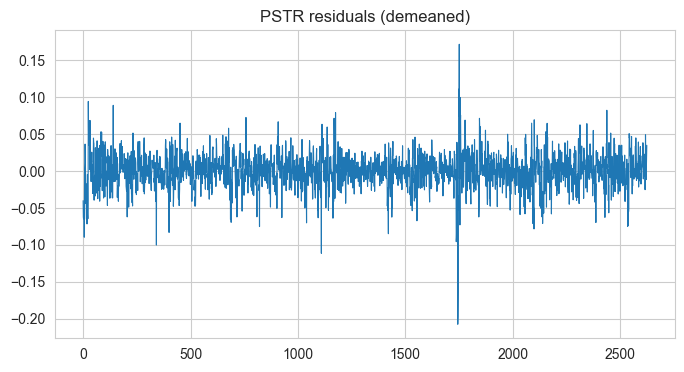

In [175]:
# Within R² using demeaned variables
y_hat_dm = pstr["ols"].fittedvalues
resid_dm = pstr["ols"].resid
r2_within = 1 - (resid_dm @ resid_dm) / (pstr["y_dm"] @ pstr["y_dm"])
print(f"Within R² (unit FE): {r2_within:.3f}")

# Quick residual plot
pd.Series(resid_dm, index=panel.index).plot(title="PSTR residuals (demeaned)", lw=0.8)
plt.xlabel(""); plt.show()


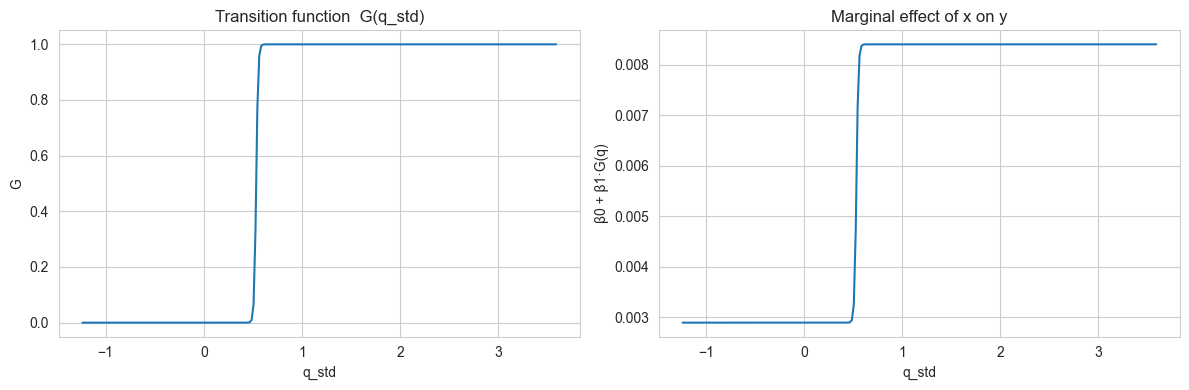

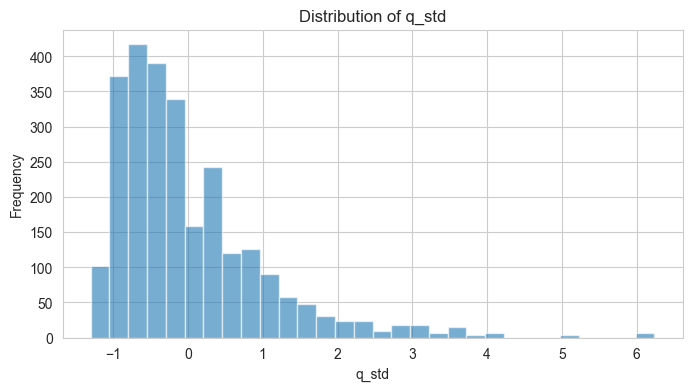

In [176]:
# Transition curve and marginal effect dE[y]/dx = β0 + β1 * G(q_std)
q_grid = np.linspace(panel["q_std"].quantile(0.01), panel["q_std"].quantile(0.99), 250)
G_grid = G_logistic(q_grid, pstr["gamma"], pstr["c"])
me_grid = pstr["beta0"] + pstr["beta1"] * G_grid

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(q_grid, G_grid)
ax[0].set_title("Transition function  G(q_std)")
ax[0].set_xlabel("q_std"); ax[0].set_ylabel("G")

ax[1].plot(q_grid, me_grid)
ax[1].set_title("Marginal effect of x on y")
ax[1].set_xlabel("q_std"); ax[1].set_ylabel("β0 + β1·G(q)")
plt.tight_layout(); plt.show()

# Where is your sample in q?
panel["q_std"].plot(kind="hist", bins=30, alpha=0.6, title="Distribution of q_std")
plt.xlabel("q_std"); plt.show()

In [177]:
G = pstr["G"]
y_dm  = unit_demean(panel["y"], panel["unit"])
x_dm  = unit_demean(panel["x"], panel["unit"])
xG_dm = unit_demean(pd.Series(panel["x"].values * G), panel["unit"])
xG2_dm= unit_demean(pd.Series(panel["x"].values * (G**2)), panel["unit"])

X2 = sm.add_constant(np.column_stack([x_dm, xG_dm, xG2_dm]))
ols2 = sm.OLS(y_dm, X2).fit(cov_type="cluster", cov_kwds={"groups": panel["date"]})

print(ols2.summary().tables[1])  # check if the x*G^2 term is (jointly) insignificant

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.783e-19      0.001  -2.59e-16      1.000      -0.001       0.001
x1             0.0029      0.001      4.510      0.000       0.002       0.004
x2             0.0055      0.057      0.096      0.923      -0.107       0.118
x3         -2.196e-08      0.057  -3.82e-07      1.000      -0.113       0.113


In [178]:
beta0, se0 = pstr["beta0"], pstr["se_beta0"]
beta1, se1 = pstr["beta1"], pstr["se_beta1"]
beta_low  = beta0
beta_high = beta0 + beta1
print(f"beta_low={beta_low:.4f}  beta_high={beta_high:.4f}")
# (If you want CIs for beta_high, use a small bootstrap, since we don’t have cov(beta0,beta1) here.)


beta_low=0.0029  beta_high=0.0084
